Processing /Users/katherineridley/Projects/PlaqueDist/Processed/C_1_M04_OC_20x_C_1_M04_OC_HI_080124_20x_plaques_analysis.csv...
Optimal number of clusters determined to be: 3
Optimal number of clusters determined to be: 3
Metrics: {'avg_distance': -422.84306708418126, 'distribution_evenness': -285306.05360218, 'plaque_density': 0.0, 'dist_from_center': -151.9385104242133, 'avg_dist_to_edge': -13.8208206134575, 'nearest_neighbor_distance': -107.55568190687062, 'optimal_clusters': 0, 'silhouette_avg': 0.16015715884636722}
KS Test Results for C_1_M04_OC_20x_C_1_M04_OC_HI_080124_20x: X Coordinates: Statistic=0.27717391304347827, P-value=1.253424892943109e-06
KS Test Results for C_1_M04_OC_20x_C_1_M04_OC_HI_080124_20x: Y Coordinates: Statistic=0.2391304347826087, P-value=5.0081955113092305e-05
Matching section: C_1
Genotype information found: APPPS1xFIRE
Processing /Users/katherineridley/Projects/PlaqueDist/Processed/F_1_M04_OC_20x_F_1_M04_OC_SSCTX_090124_20x_plaques_analysis.csv...
Optimal

/Users/katherineridley/anaconda3/envs/plaquedist/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


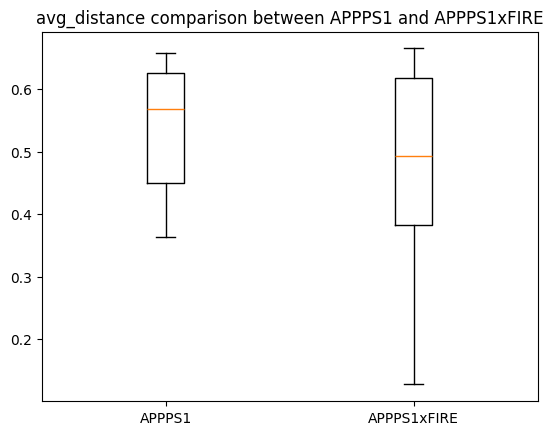

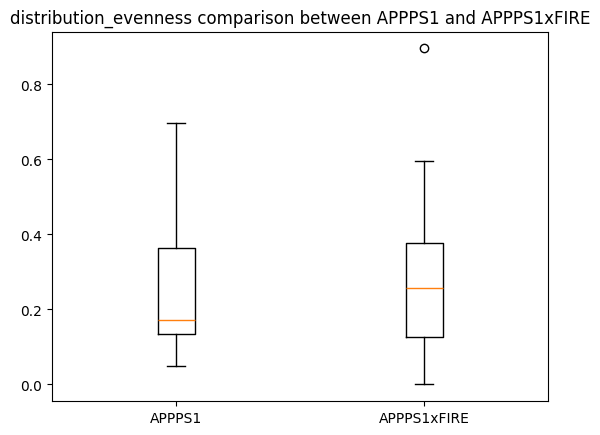

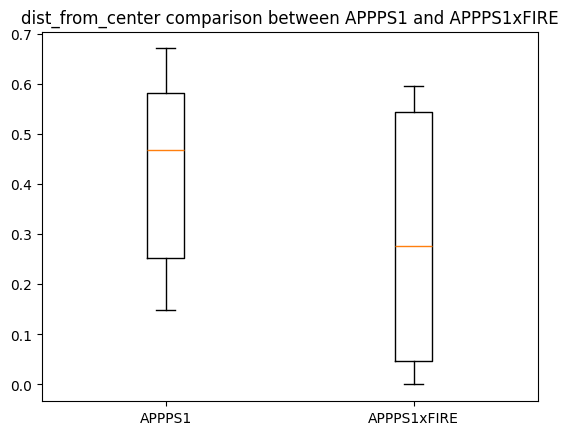

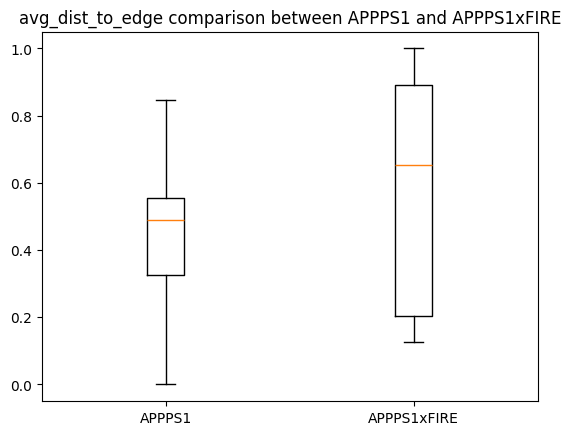

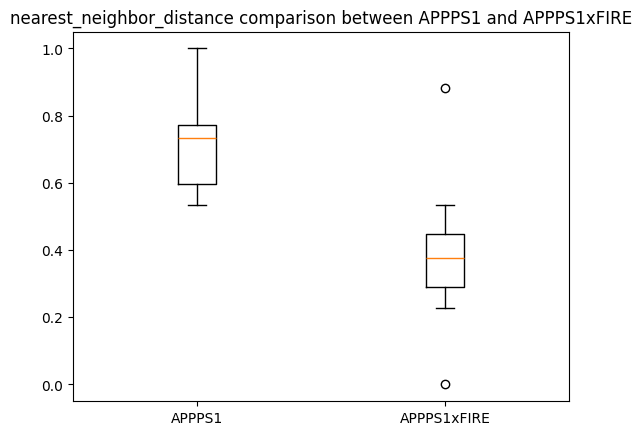

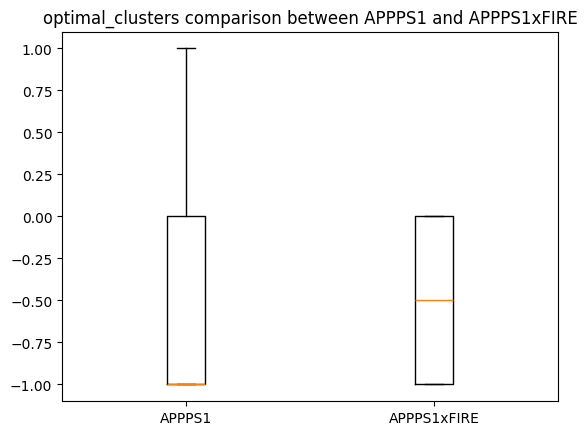

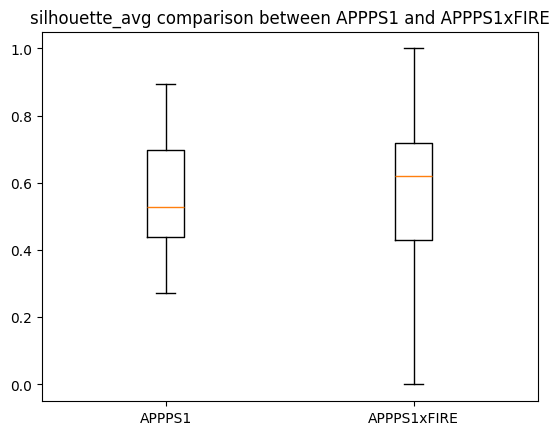

T-test results saved.
Processing complete. Results with genotype information saved.


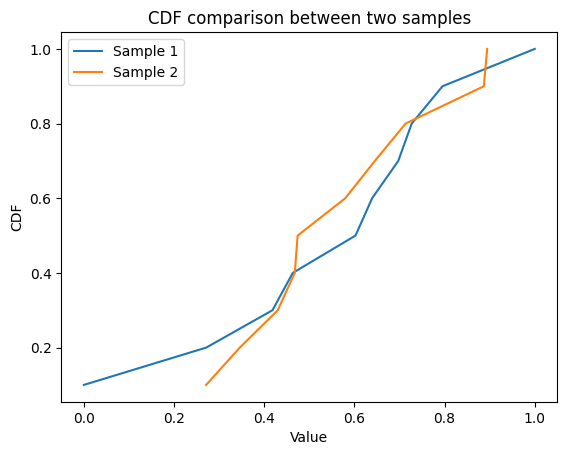

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.stats import ks_2samp
from sklearn.metrics import silhouette_samples, silhouette_score
import os
import glob
from skimage import io
from sklearn.cluster import KMeans
from kneed import KneeLocator
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

def generate_random_distribution(data, image_size):
    x_min, x_max = data['centroid_x'].min(), data['centroid_x'].max()
    y_min, y_max = data['centroid_y'].min(), data['centroid_y'].max()
    num_points = len(data)
    random_x = np.random.uniform(low=x_min, high=x_max, size=num_points)
    random_y = np.random.uniform(low=y_min, high=y_max, size=num_points)
    return np.column_stack((random_x, random_y))

def calculate_characteristics(centroids, image_size):
    distances = squareform(pdist(centroids))
    avg_distance = np.mean(distances[np.nonzero(distances)])
    distribution_evenness = np.var(distances[np.nonzero(distances)])
    plaque_density = (len(centroids) / (image_size[0] * image_size[1])) * 10000
    center_of_image = np.array([image_size[0] / 2, image_size[1] / 2])
    dist_from_center = np.mean(cdist(centroids, [center_of_image]))
    avg_dist_to_edge = _calculate_avg_distance_to_edge(centroids, image_size)
    
    optimal_clusters = calculate_optimal_clusters(centroids)
    labels, _ = perform_kmeans_clustering(centroids, optimal_clusters)
    
    
    if optimal_clusters > 1:
        silhouette_avg = silhouette_score(centroids, labels)
    else:
        silhouette_avg = -1  # Or any indicator value for invalid/undefined cases
  
    nearest_neighbor_distance = calculate_nearest_neighbor_distance(centroids)
    
    return {'avg_distance':avg_distance, 
            'distribution_evenness':distribution_evenness,
            'plaque_density':plaque_density,
            'dist_from_center':dist_from_center,
            'avg_dist_to_edge':avg_dist_to_edge,
            'nearest_neighbor_distance':nearest_neighbor_distance,
            'optimal_clusters':optimal_clusters,
            'silhouette_avg':silhouette_avg}
            

def calculate_nearest_neighbor_distance(centroids):
    distances = squareform(pdist(centroids))
    np.fill_diagonal(distances, np.inf)
    nearest_neighbor_dist = np.min(distances, axis=1)
    return np.mean(nearest_neighbor_dist)

def calculate_optimal_clusters(data, max_clusters=10):
        
        wcss = []  # Within-cluster sum of squares
        for i in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
            kmeans.fit(data)
            wcss.append(kmeans.inertia_)
        
        # Use the KneeLocator to find the elbow point
        kneedle = KneeLocator(range(1, max_clusters + 1), wcss, curve='convex', direction='decreasing')
        optimal_clusters = kneedle.elbow
        
        if optimal_clusters is None:
            raise ValueError("Optimal number of clusters could not be determined automatically.")
        
        print(f"Optimal number of clusters determined to be: {optimal_clusters}")
        return optimal_clusters

def perform_kmeans_clustering(data, n_clusters):
    
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(data)
    centroids = kmeans.cluster_centers_
    return labels, centroids

def _calculate_avg_distance_to_edge(centroids, image_size):
    dist_to_edge = []
    for centroid in centroids:
        distances = [centroid[0], image_size[0] - centroid[0], centroid[1], image_size[1] - centroid[1]]
        dist_to_edge.append(min(distances))
    return np.mean(dist_to_edge)

def identify_region(image_name):
    if 'HI' in image_name:
        return 'HI'
    elif 'SSCTX' in image_name:
        return 'SSCTX'
    else:
        return 'Other'

def perform_ks_test(real_data, random_data):
    return ks_2samp(real_data, random_data)

def perform_t_test(real_data, random_data):
    return ttest_ind(real_data, random_data)

def save_ks_descriptive_stats(aggregated_results):
    df = pd.DataFrame(aggregated_results)

    # Compute mean of KS statistics by region and genotype
    stats_summary = df.groupby(['region', 'genotype'])[['ks_stat_x', 'ks_pvalue_x', 'ks_stat_y', 'ks_pvalue_y']].mean().reset_index()

    # Save the summary statistics to a CSV file
    stats_summary.to_csv("ks_stats_summary_by_region_and_genotype.csv", index=False)
    print("KS descriptive statistics saved by region and genotype.")

def save_t_test_descriptive_stats(aggregated_results):
    df = pd.DataFrame(aggregated_results)

    # Compute mean of T statistics by region and genotype
    stats_summary = df.groupby(['region', 'genotype'])[['t_stat_x', 't_pvalue_x', 't_stat_y', 't_pvalue_y']].mean().reset_index()

    # Save the summary statistics to a CSV file
    stats_summary.to_csv("t_test_stats_summary_by_region_and_genotype.csv", index=False)
    print("T-test descriptive statistics saved by region and genotype.")





def main():
    plots =  "/Users/katherineridley/Projects/PlaqueDist/Plots"
    processed_path = "/Users/katherineridley/Projects/PlaqueDist/Processed"
    masks_path = "/Users/katherineridley/Projects/PlaqueDist/Masks"
    random_dists_path = "/Users/katherineridley/Projects/PlaqueDist/RandomDists"
    genotype_key_path = "/Users/katherineridley/Projects/PlaqueDist/genotypekey.csv"

    # Ensure the directory for random distributions exists
    os.makedirs(random_dists_path, exist_ok=True)

    # Load the genotype key
    genotypekey = pd.read_csv(genotype_key_path)
    
    # Modify this to match your genotypekey structure
    genotypekey['Section'] = genotypekey['image_name'].apply(lambda x: x[:3])

    real_results = []
    random_results = []
    aggregated_results = []

    for csv_file in glob.glob(os.path.join(processed_path, "*.csv")):
        base_name = os.path.basename(csv_file).replace('_plaques_analysis.csv', '')
        print(f"Processing {csv_file}...")

        # Attempting to match mask image based on naming pattern differences
        corresponding_mask = glob.glob(f"{masks_path}/{base_name}*__M04.tiff")
        
        if corresponding_mask:
            image_path = corresponding_mask[0]
            

            imagestack = io.imread(image_path)
            image_dimensions = [imagestack.shape[1], imagestack.shape[2]]

            data = pd.read_csv(csv_file)
            real_centroids = data[['centroid_x', 'centroid_y']].values

            # Your analytical steps here: calculate_characteristics, generate_random_distribution, etc.
            real_metrics = calculate_characteristics(real_centroids, image_dimensions)

            # Generate random distribution
            random_centroids = generate_random_distribution(data, image_dimensions)
            random_metrics = calculate_characteristics(random_centroids, image_dimensions)

            #normalise metrics to between 0 and 1 
            
                #real_metrics[metric] = (real_metrics[metric] - real_metrics[metric].min()) / (real_metrics[metric].max() - real_metrics[metric].min())
                #random_metrics[metric] = (random_metrics[metric] - random_metrics[metric].min()) / (random_metrics[metric].max() - random_metrics[metric].min())
                #metric_differences[f'{metric}'] = real_metrics[metric] - random_metrics[metric]
                
            
            metric_differences = {metric: real_metrics[metric] - random_metrics[metric] for metric in real_metrics}
            print(f"Metrics: {metric_differences}")
            #normalise metrics to between 0 and 1

            
            # Perform KS test
            ks_result_x = perform_ks_test(real_centroids[:, 0], random_centroids[:, 0])
            ks_result_y = perform_ks_test(real_centroids[:, 1], random_centroids[:, 1])

            print(f"KS Test Results for {base_name}: X Coordinates: Statistic={ks_result_x.statistic}, P-value={ks_result_x.pvalue}")
            print(f"KS Test Results for {base_name}: Y Coordinates: Statistic={ks_result_y.statistic}, P-value={ks_result_y.pvalue}")

            t_result_x = perform_t_test(real_centroids[:, 0], random_centroids[:, 0])
            t_result_y = perform_t_test(real_centroids[:, 1], random_centroids[:, 1])

            



            # Section to match and use genotype key information
            # Exemplary matching, adjust as necessary for your project specifics
            base_name = os.path.basename(csv_file).replace('_plaques_analysis.csv', '')
    
            # Adjust this line to correctly extract the intended matching part of the file name
            file_section = '_'.join(base_name.split('_')[0:2])  # Adjust based on your naming convention
            print(f"Matching section: {file_section}")

            # Now use this 'file_section' for matching
            genotype_info = genotypekey[genotypekey['Section'] == file_section]

        
            # Assuming there's one match per section
            if not genotype_info.empty:
                print(f"Genotype information found: {genotype_info['Genotype'].iloc[0]}")
                genotype = genotype_info['Genotype'].iloc[0]
                real_metrics['genotype'] = genotype
                random_metrics['genotype'] = genotype
                real_metrics['filename'] = base_name
                random_metrics['filename'] = base_name
                region = identify_region(base_name)  
                real_metrics['region'] = region
                random_metrics['region'] = region
                metric_differences['region'] = region 
                

                
                real_results.append(real_metrics)
                random_results.append(random_metrics)

                results_entry = {
                    'filename': base_name, 'genotype': genotype, 't_stat_x': t_result_x.statistic, 't_pvalue_x': t_result_x.pvalue, 't_stat_y': t_result_y.statistic, 't_pvalue_y': t_result_y.pvalue,
                    'ks_stat_x': ks_result_x.statistic, 'ks_pvalue_x': ks_result_x.pvalue, 'ks_stat_y': ks_result_y.statistic, 'ks_pvalue_y': ks_result_y.pvalue,
                      **metric_differences
                }

                aggregated_results.append(results_entry)

                
                

                avgxy = np.mean(real_centroids, axis=0)
                randomavgxy = np.mean(random_centroids, axis=0)
                data1 = np.sort(avgxy)
                data2 = np.sort(randomavgxy)
                cdf1 = np.arange(1, len(data1)+1) / len(data1)
                cdf2 = np.arange(1, len(data2)+1) / len(data2)

                plt.plot(data1, cdf1, label='Real X')
                plt.plot(data2, cdf2, label='Random X')
                plt.ylabel('CDF')
                plt.xlabel('Value')
                plt.legend()
                plt.title(f'CDF comparison {base_name} - Genotype: {genotype}')
            
                plt.savefig(os.path.join(plots, f"{base_name}_CDF.png"))
                plt.close()

                #scatterplot
                plt.scatter(real_centroids[:, 0], real_centroids[:, 1], label='Real')
                plt.scatter(random_centroids[:, 0], random_centroids[:, 1], label='Random')
                plt.legend()
                plt.title(f'Scatterplot comparison {base_name} - Genotype: {genotype}')
                plt.savefig(os.path.join(plots, f"{base_name}_scatterplot.png"))
                plt.close()
            else:
                print("No genotype information found.")

                # Conducting T-tests between genotypes and regions and store as CSVs

    save_ks_descriptive_stats(aggregated_results)
    save_t_test_descriptive_stats(aggregated_results)
    df_aggregated_results = pd.DataFrame(aggregated_results)

    #normalise metrics to between 0 and 1

    for metric in ['avg_distance', 'distribution_evenness', 'dist_from_center', 'avg_dist_to_edge', 'nearest_neighbor_distance', 'silhouette_avg']:
        q1 = df_aggregated_results[metric].quantile(0.2)
        q3 = df_aggregated_results[metric].quantile(0.8)
        iqr = q3 - q1
        df_aggregated_results = df_aggregated_results[(df_aggregated_results[metric] > q1 - 1.5 * iqr) & (df_aggregated_results[metric] < q3 + 1.5 * iqr)]
        df_aggregated_results[metric] = (df_aggregated_results[metric] - df_aggregated_results[metric].min()) / (df_aggregated_results[metric].max() - df_aggregated_results[metric].min())
        #box plot per metric
        
    # Split data by region - you may loop through regions to filter dfs
    regions = df_aggregated_results['region'].unique()
    t_test_results = []  # List to store results
    for region in regions:
        df_region = df_aggregated_results[df_aggregated_results['region'] == region]
        genotypes = df_region['genotype'].unique()
        for metric in ['avg_distance', 'distribution_evenness', 'dist_from_center', 'avg_dist_to_edge', 'nearest_neighbor_distance', 'optimal_clusters', 'silhouette_avg']:

            #remove outliers
            q1 = df_region[metric].quantile(0.1)
            q3 = df_region[metric].quantile(0.9)
            iqr = q3 - q1
            df_region = df_region[(df_region[metric] > q1 - 1.5 * iqr) & (df_region[metric] < q3 + 1.5 * iqr)]
            
            
            if len(genotypes) > 1:
                data1 = df_region[df_region['genotype'] == genotypes[0]][metric]
                data2 = df_region[df_region['genotype'] == genotypes[1]][metric]
                stat, p = ttest_ind(data1, data2)
                t_test_results.append({'region': region, 'metric': metric, 'genotype1': genotypes[0], 'genotype2': genotypes[1], 'stat': stat, 'p-value': p})

    pd.DataFrame(t_test_results).to_csv("t_test_results_by_region.csv", index=False)
    print("T-test results saved.")
    t_test_results = []  # List to store results
    
    genotypes = df_aggregated_results['genotype'].unique()
    for metric in ['avg_distance', 'distribution_evenness', 'dist_from_center', 'avg_dist_to_edge', 'nearest_neighbor_distance', 'optimal_clusters', 'silhouette_avg']:
            #remove outliers
            
            plt.boxplot([df_aggregated_results[df_aggregated_results['genotype'] == 'APPPS1'][metric], df_aggregated_results[df_aggregated_results['genotype'] == 'APPPS1xFIRE'][metric]], labels=['APPPS1', 'APPPS1xFIRE'])
            #title metric
            plt.title(f'{metric} comparison between APPPS1 and APPPS1xFIRE')
            plt.show()
            plt.savefig(os.path.join(plots, f"{metric}_boxplot.png"))
            if len(genotypes) > 1:
                data1 = df_aggregated_results[df_aggregated_results['genotype'] == genotypes[0]][metric]
                data2 = df_aggregated_results[df_aggregated_results['genotype'] == genotypes[1]][metric]
                stat, p = ttest_ind(data1, data2)
                t_test_results.append({'metric': metric, 'genotype1': genotypes[0], 'genotype2': genotypes[1], 'stat': stat, 'p-value': p})

    # Conversion to DataFrame and saving to CSV
    pd.DataFrame(t_test_results).to_csv("t_test_results.csv", index=False)
    print("T-test results saved.")

    # Convert results to DataFrame and additional processing if necessary
    
    df_aggregated_results.to_csv("aggregated_differences_with_genotype.csv", index=False)
    realresults_df = pd.DataFrame(real_results)
    randomresults_df = pd.DataFrame(random_results)
    realresults_df.to_csv("aggregated_real_results_with_genotype.csv", index=False)
    randomresults_df.to_csv("aggregated_random_results_with_genotype.csv", index=False)
    print("Processing complete. Results with genotype information saved.")

    data1 = np.sort(data1)
    data2 = np.sort(data2)
    cdf1 = np.arange(1, len(data1)+1) / len(data1)
    cdf2 = np.arange(1, len(data2)+1) / len(data2)

    plt.plot(data1, cdf1, label='Sample 1')
    plt.plot(data2, cdf2, label='Sample 2')
    plt.ylabel('CDF')
    plt.xlabel('Value')
    plt.legend()
    plt.title('CDF comparison between two samples')
    plt.show()

if __name__ == "__main__":
    main()



In [2]:
pip install scikit-learn kneed

  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 10.7 MB/s eta 0:00:00a 0:00:01
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
#print working directory

import os
os.getcwd()

#change working directory

os.chdir('/Users/katherineridley/Projects/PlaqueDist/')
